In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('Salary_data_Cleaned.csv')

In [3]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'job_state', 'same_state', 'age', 'python', 'sql', 'excel', 'tableau',
       'desc_length', 'job_simplified', 'seniority', 'num_comp'],
      dtype='object')

### Choosing Relevant Columns

In [4]:
df_model=df[['avg_salary','Rating','Size','Type of ownership','Industry', 'Sector', 'Revenue','hourly', 'employer_provided','job_state', 'same_state', 'age', 'python', 'sql', 'excel', 'tableau',
       'desc_length', 'job_simplified', 'seniority', 'num_comp']]

### Get dummy data

In [5]:
df_dum=pd.get_dummies(df_model,drop_first=True)

#### Train Test Split

In [6]:
X=df_dum.drop('avg_salary',axis=1)
Y=df_dum.avg_salary.values

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.33,random_state=42)

### Model Selection

#### Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
lr=LinearRegression()

In [9]:
lr.fit(X_train,y_train)
np.mean(cross_val_score(lr,X_train,y_train,scoring='neg_mean_absolute_error'))

-20.671586684369096

#### Lasso Regression

In [10]:
from sklearn.linear_model import Lasso
lasso=Lasso()

In [11]:
lasso.fit(X_train,y_train)
np.mean(cross_val_score(lasso,X_train,y_train,scoring='neg_mean_absolute_error'))

-22.284817905804253

c:\Users\dhruv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.303e+02, tolerance: 6.088e+01
  model = cd_fast.enet_coordinate_descent(


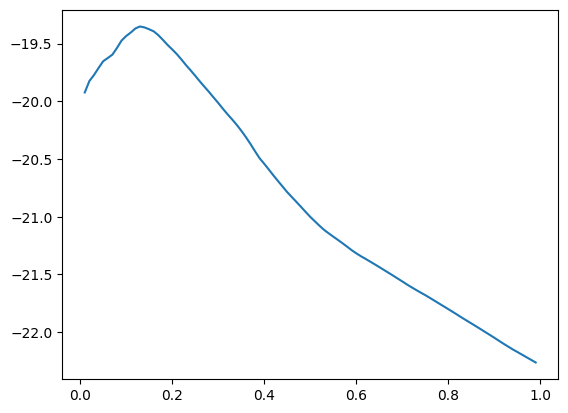

In [12]:
alpha=[]
error=[]

for i in range(1,100):
    alpha.append(i/100)
    lasso=Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lasso,X_train,y_train,scoring='neg_mean_absolute_error')))
plt.plot(alpha,error)

In [13]:
err=tuple(zip(alpha,error))
df_error=pd.DataFrame(err,columns=['alpha','error'])

In [14]:
df_error[df_error.error==max(df_error.error)]

,alpha,error
12,0.13,-19.351153


In [15]:
lasso_2=Lasso(alpha=0.13)
lasso_2.fit(X_train,y_train)

Lasso(alpha=0.13)

#### Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()

In [17]:
np.mean(cross_val_score(rf,X_train,y_train,scoring='neg_mean_absolute_error'))


-16.41519222222222

#### Tuning Using GridSearchCV

In [18]:
from sklearn.model_selection import GridSearchCV
parameter = {
    'n_estimators': range(10, 300, 10),
    'criterion': ('mse', 'squared_error'),
    'max_features': ('auto', 'sqrt', 'log2')
}

In [19]:
gs=GridSearchCV(rf,parameter,scoring='neg_mean_absolute_error')

In [20]:
gs.fit(X_train,y_train)

c:\Users\dhruv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
580 fits failed out of a total of 870.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
435 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dhruv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dhruv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\dhruv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'criterion': ('mse', 'squared_error'),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': range(10, 300, 10)},
             scoring='neg_mean_absolute_error')

In [21]:
gs.best_score_

-16.15658237934905

In [22]:
gs.best_estimator_

RandomForestRegressor(max_features='sqrt', n_estimators=270)

In [23]:
t_pred_lr=lr.predict(X_test)
t_pred_lasso=lasso_2.predict(X_test)
t_pred_rf=gs.best_estimator_.predict(X_test)

In [24]:
from sklearn.metrics import mean_absolute_error

In [25]:
print(mean_absolute_error(y_test,t_pred_lr))
print(mean_absolute_error(y_test,t_pred_lasso))
print(mean_absolute_error(y_test,t_pred_rf))


19.377381189003888
19.907247371467264
13.357996976568403


In [26]:
import pickle

In [27]:
pickl={'model':gs.best_estimator_}
pickle.dump(pickl,open('model_file'+'.p','wb'))